In [34]:
from init_nb import init_notebook
config = init_notebook()

from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import numpy as np
import seaborn as sns
from nilearn import plotting
import nibabel as nib
import itertools
from bold_dementia.connectivity import Atlas, group_by_networks, plot_matrix, reshape_pvalues, block_block
from bold_dementia.utils.iterables import unique

ATLAS = "schaeffer200"
SOFT = False
ALPHA = config["alpha"]

In [35]:
atlas = Atlas.from_name(ATLAS, soft=SOFT)
coords = atlas.get_coords()

In [36]:
expname = f"atlas-{ATLAS}_default_ols-cenanom"
matrices_path = Path(
    f"{config['output_dir']}/statresults/{expname}"
)
print(f"Loading matrices from {matrices_path}")
try:
    fdrmat = joblib.load(matrices_path / "pmat.joblib")
    tstats = joblib.load(matrices_path / "statmap.joblib")
except FileNotFoundError:
    print("Fetching results from resdf")

#n_AD = AD_matrices.shape[0]
#n_controls = control_matrices.shape[0]

atlas = Atlas.from_name(ATLAS, soft=SOFT)
n_regions = len(atlas.labels)

thresholded_t = tstats * np.where(fdrmat < ALPHA, 1, 0)
labels = tuple(sorted(unique(atlas.macro_labels)))

Loading matrices from /homes_unix/jlegrand/data/Memento/output/statresults/atlas-schaeffer200_default_ols-cenanom


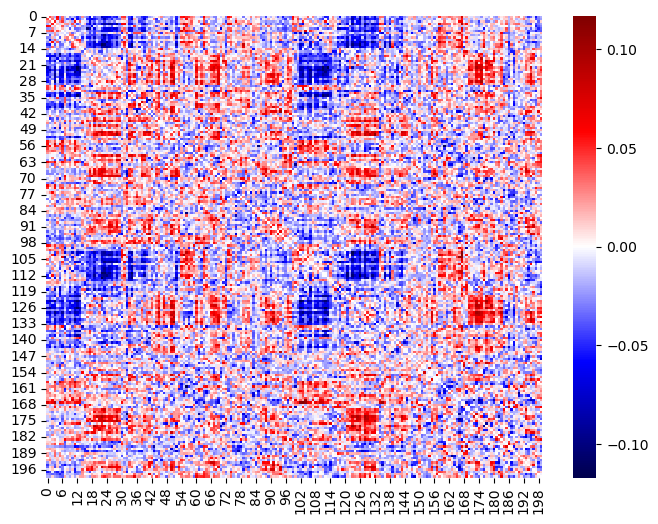

In [66]:
span = np.max(np.abs(thresholded_t))

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

sns.heatmap(
    tstats,
    #xticklabels=labels,
    #yticklabels=labels,
    #title=f"{expname}\nthresholded t-values map",
    axes=ax,
    cmap="seismic",
    #grid=True,
    vmin=-span,
    vmax=span,
    #linewidths=0.1,
    #linecolor="gray",
    #linestyle="--"
)
#plt.setp(ax.xaxis.get_majorticklabels(), ha="center", rotation_mode="anchor")
plt.show()

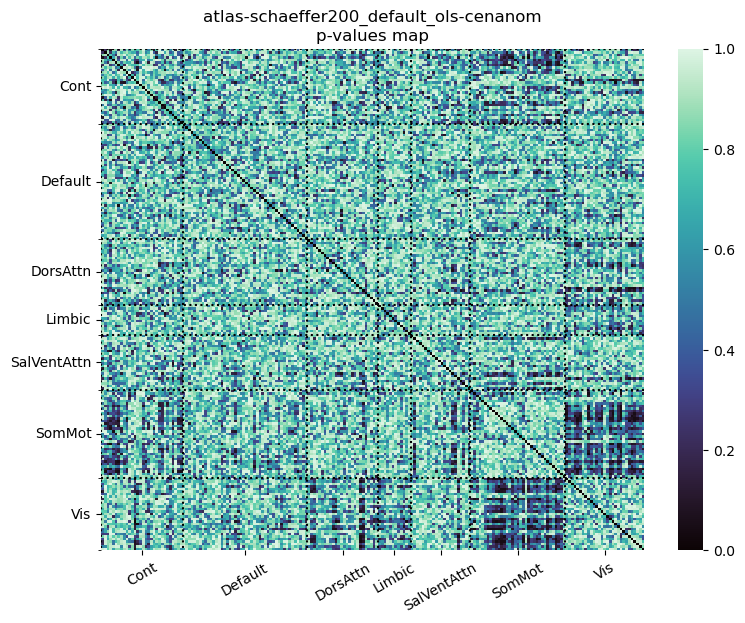

In [38]:
from bold_dementia.connectivity import plot_ordered_matrix

plot_matrix(fdrmat, atlas, bounds=(0, 1), cmap="mako")
plt.title(f"{expname}\np-values map")
plt.show()

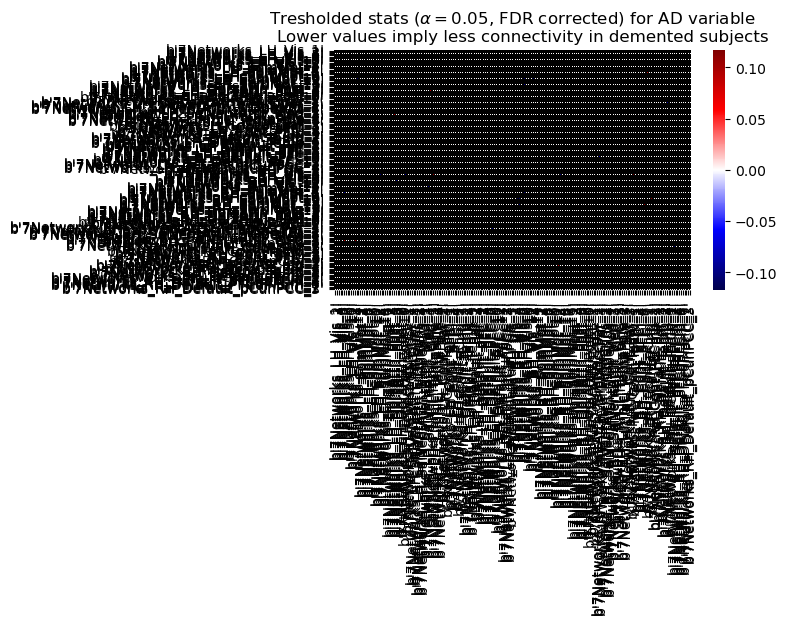

In [39]:

thresholded_t = tstats * np.where(fdrmat < ALPHA, 1, 0)

plot_ordered_matrix(thresholded_t, atlas)

plt.title("Tresholded stats ($\\alpha = 0.05$, FDR corrected) for AD variable\n\
    Lower values imply less connectivity in demented subjects")
plt.show()

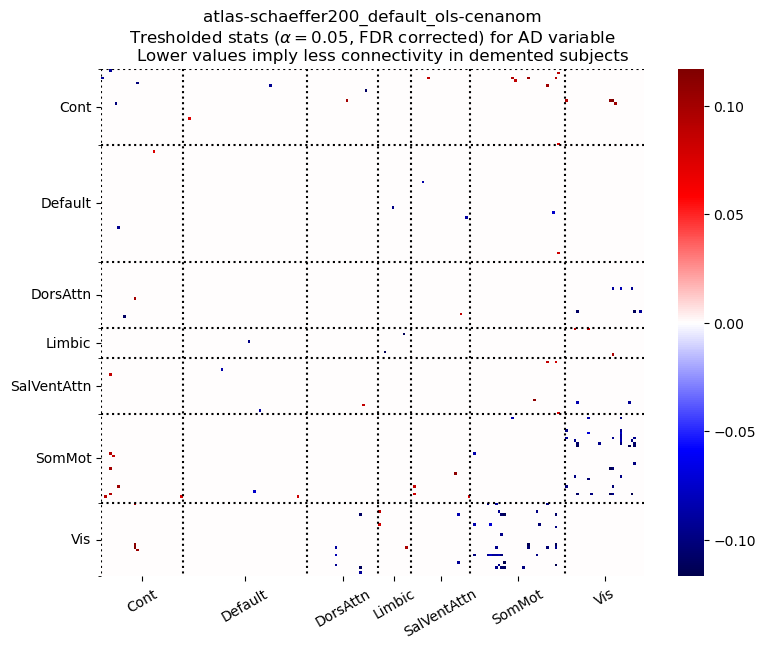

In [40]:
plot_matrix(thresholded_t, atlas)
plt.title(f"{expname}\nTresholded stats ($\\alpha = 0.05$, FDR corrected) for AD variable\n\
    Lower values imply less connectivity in demented subjects")
plt.show()

In [41]:
ticks, sort_index = group_by_networks(atlas.macro_labels)
block_mat = thresholded_t[np.ix_(sort_index, sort_index)]

In [42]:
labels = [label for label in atlas.labels if label != "Background"]
dict(zip(labels, atlas.macro_labels))

{b'7Networks_LH_Vis_1': 'Vis',
 b'7Networks_LH_Vis_2': 'Vis',
 b'7Networks_LH_Vis_3': 'Vis',
 b'7Networks_LH_Vis_4': 'Vis',
 b'7Networks_LH_Vis_5': 'Vis',
 b'7Networks_LH_Vis_6': 'Vis',
 b'7Networks_LH_Vis_7': 'Vis',
 b'7Networks_LH_Vis_8': 'Vis',
 b'7Networks_LH_Vis_9': 'Vis',
 b'7Networks_LH_Vis_10': 'Vis',
 b'7Networks_LH_Vis_11': 'Vis',
 b'7Networks_LH_Vis_12': 'Vis',
 b'7Networks_LH_Vis_13': 'Vis',
 b'7Networks_LH_Vis_14': 'Vis',
 b'7Networks_LH_SomMot_1': 'SomMot',
 b'7Networks_LH_SomMot_2': 'SomMot',
 b'7Networks_LH_SomMot_3': 'SomMot',
 b'7Networks_LH_SomMot_4': 'SomMot',
 b'7Networks_LH_SomMot_5': 'SomMot',
 b'7Networks_LH_SomMot_6': 'SomMot',
 b'7Networks_LH_SomMot_7': 'SomMot',
 b'7Networks_LH_SomMot_8': 'SomMot',
 b'7Networks_LH_SomMot_9': 'SomMot',
 b'7Networks_LH_SomMot_10': 'SomMot',
 b'7Networks_LH_SomMot_11': 'SomMot',
 b'7Networks_LH_SomMot_12': 'SomMot',
 b'7Networks_LH_SomMot_13': 'SomMot',
 b'7Networks_LH_SomMot_14': 'SomMot',
 b'7Networks_LH_SomMot_15': 'SomMot',


In [43]:
unique_m = sorted(tuple(unique(atlas.macro_labels)))
network_to_idx = pd.Series(dict(zip(
    unique_m,
    itertools.pairwise(ticks)
)))
network_to_idx

Cont              (0, 30)
Default          (30, 76)
DorsAttn        (76, 102)
Limbic         (102, 114)
SalVentAttn    (114, 136)
SomMot         (136, 171)
Vis            (171, 200)
dtype: object

In [61]:
gen = block_block(block_mat, network_to_idx)
comparisons = pd.DataFrame(gen, columns=["node_a", "node_b", "npos", "nneg", "activation"])

In [62]:
comparisons_pv = comparisons.pivot(index="node_a", columns="node_b")

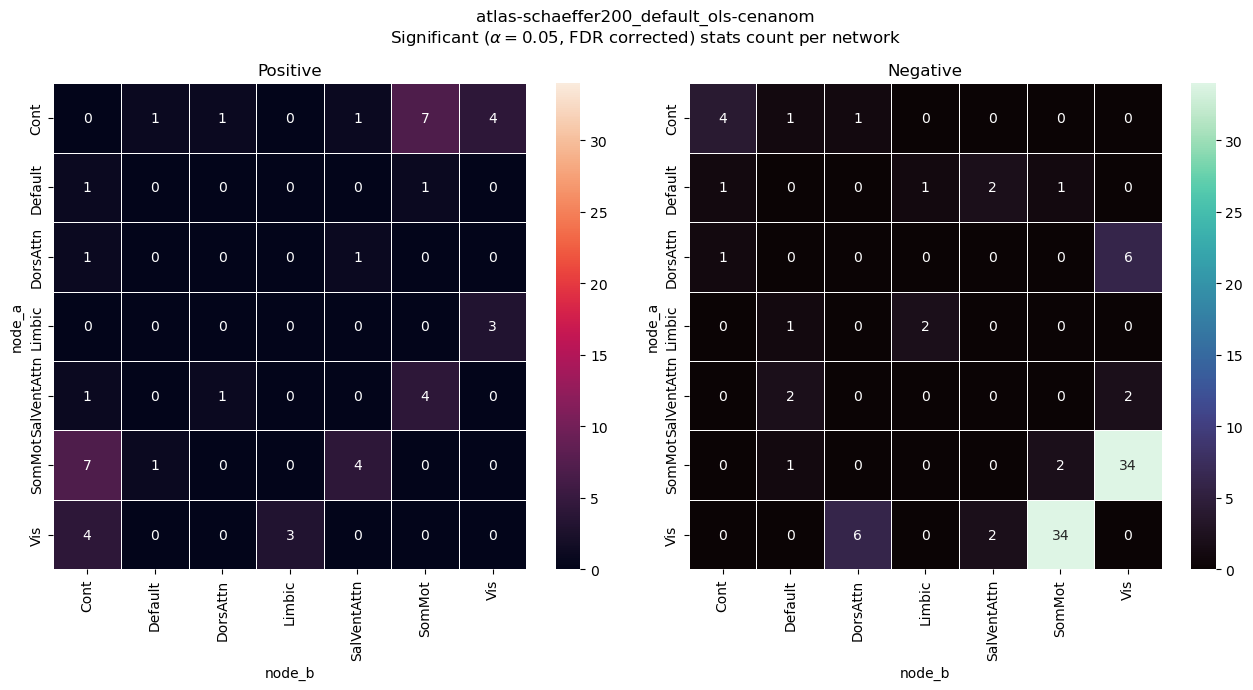

In [63]:
max_count = max(comparisons[["npos", "nneg"]].max())

heat_kwargs = {
    "xticklabels":unique_m,
    "yticklabels":unique_m,
    "vmax": max_count,
    "annot": True,
    "linewidth": 0.5
}

fig, axes = plt.subplots(1, 2, figsize=(13, 7))
sns.heatmap(comparisons_pv.loc[:, "npos"], **heat_kwargs, cmap="rocket", ax=axes[0])
axes[0].set_title("Positive")

sns.heatmap(comparisons_pv.loc[:, "nneg"], **heat_kwargs, cmap="mako", ax=axes[1])
axes[1].set_title("Negative")
fig.suptitle(f"{expname}\nSignificant ($\\alpha = 0.05$, FDR corrected) stats count per network")
fig.tight_layout()
fig.show()

In [ ]:
tuple(unique(atlas.macro_labels))

('Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default')

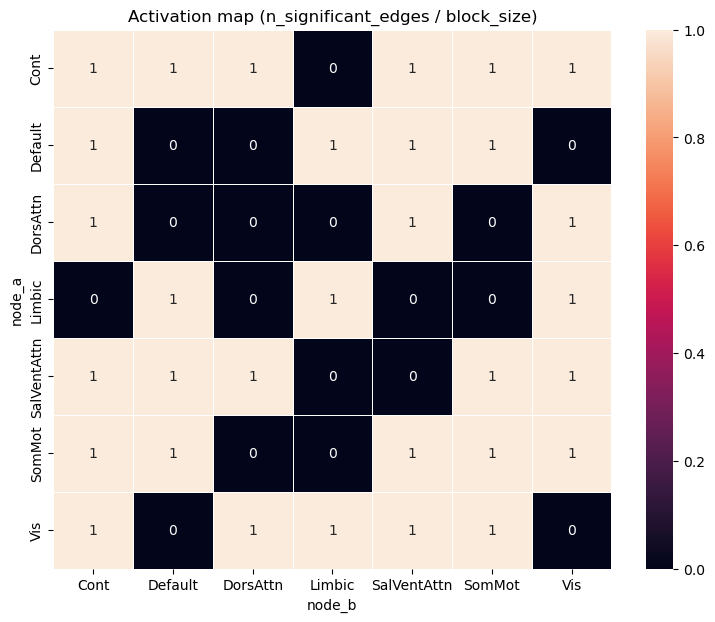

In [ ]:
heat_k2 = heat_kwargs.copy()
heat_k2.pop("vmax")
plt.subplots(1, 1, figsize=(9, 7))
sns.heatmap(comparisons_pv.loc[:, "activation"], **heat_k2)
plt.title("Activation map (n_significant_edges / block_size)")
plt.show()

In [ ]:
view = plotting.view_connectome(tstats, coords, edge_threshold="99%")
view.open_in_browser()